In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import torch.nn as nn
import torch

In [7]:
# %%writefile box_gen.py

import numpy as np
from PIL import Image, ImageDraw

FRAME_SIZE = [5,50]
BOX_WIDTH = 3


def get_rect(x, y, width, height):
    rect = np.array([(0, 0), (width-1, 0), (width-1, height-1), (0, height-1), (0, 0)])
    offset = np.array([x, y])
    transformed_rect = rect + offset
    return transformed_rect

def get_array_with_box_at_pos(x):
    data = np.zeros(FRAME_SIZE)
    img = Image.fromarray(data)
    draw = ImageDraw.Draw(img)
    rect = get_rect(x=x, y=1, width=BOX_WIDTH, height=BOX_WIDTH)
    draw.polygon([tuple(p) for p in rect], fill=1)
    new_data = np.asarray(img)
    return new_data

In [9]:
sway_offset = 1
sway_start = sway_offset
sway_end = (FRAME_SIZE[1]-1) - BOX_WIDTH
sway_range = sway_end - sway_offset
sway_start, sway_end, sway_range

(1, 46, 45)

In [11]:
DATA_POINTS = 100

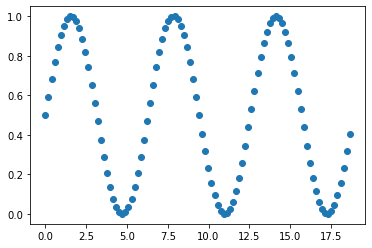

In [13]:
base = (np.arange(DATA_POINTS, dtype=np.float32)/DATA_POINTS)* 6 *np.pi
sined = (np.sin(base, dtype=np.float32) + 1)/2
plt.scatter(base, sined)
plt.show()

In [15]:
def sin_to_pos(sin_val):
    return (sin_val*sway_range)+sway_offset

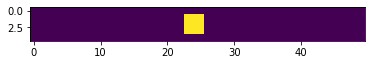

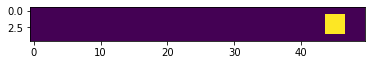

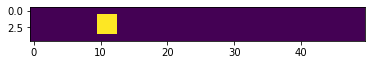

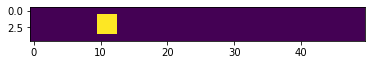

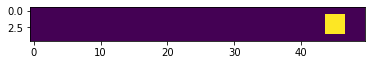

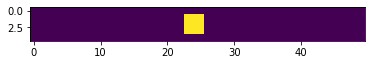

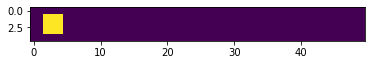

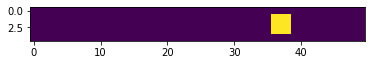

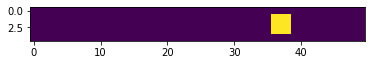

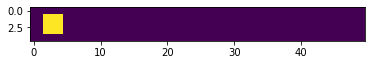

In [17]:
# #############
# sined = sined[:35]
# #############
frames = []

print_every_n_frames = DATA_POINTS//10
for i,t in enumerate(sined):
    frame = get_array_with_box_at_pos(sin_to_pos(t))
    if(i % print_every_n_frames)==0:
        plt.imshow(frame, interpolation='nearest')
        plt.show()
    frames.append(frame)

In [19]:
y = sin_to_pos(sined[1:])
X = frames[:-1]

len(X), len(y)

(99, 99)

In [21]:
with open('sliding_square_target.npy', 'wb') as file:
    np.save(arr=y, file=file)

with open('sliding_square.npy', 'wb') as file:
    np.save(arr=X, file=file)

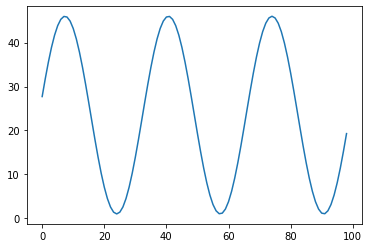

In [23]:
plt.plot(y)

In [25]:
X = np.array(X, dtype = np.float32)
y = np.array(y, dtype = np.float32)
chron_X = np.zeros([X.shape[0]-1, 2, X.shape[1], X.shape[2]], dtype = np.float32)
chron_y = y[1:]

# stack the input frames in sequencial pairs
chron_X[:,0,:,:] = X[:-1]
chron_X[:,1,:,:] = X[1:]

chron_X = np.expand_dims(chron_X, 2) # add channel dim
chron_y = np.expand_dims(chron_y, -1) # add channel dim
chron_X.shape, chron_y.shape
# chron_X.dtype, chron_y.dtype

((98, 2, 1, 5, 50), (98, 1))

first input frame


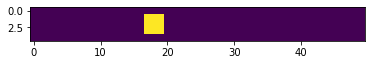

second input frame


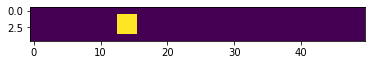

result y frame
/home/praskr/anaconda3/envs/ml-pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


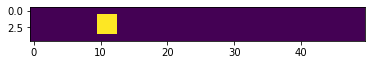

In [27]:
# look a input out for sanity

i = 18
print('first input frame')
plt.imshow(chron_X[i,0,0,:,:])
plt.show()

print('second input frame')
plt.imshow(chron_X[i,1,0,:,:])
plt.show()

print('result y frame')
plt.imshow(get_array_with_box_at_pos(chron_y[i]))
plt.show()

In [29]:
from torchdun.data import Dataclass, load_wiggle

trainset = Dataclass(chron_X, chron_y)
# valset = Dataclass(X,Y)

batch_size = 10
n_cpu = 12
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,                                                      pin_memory=True, num_workers=n_cpu)
# valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False,                                                         pin_memory=True, num_workers=n_cpu)


In [31]:
from dun import dun_convlstm
n_epoch = 1000
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = dun_convlstm(n_layer=1).to(device)

In [33]:
optim = torch.optim.RMSprop(model.parameters(), lr=0.001, eps=1e-07)
# optim = torch.optim.Adam(model.parameters(), lr=0.001
#                          , weight_decay=0.0001
#                          )
def MAPE(y_true, y_pred):
    return torch.mean(torch.abs( (y_true - y_pred)/ y_true ))*100
criterion = MAPE
# criterion = nn.L1Loss()

In [35]:
x, y = next(iter(trainloader))
print(x.shape)
y_bar = model(x.to(device))
print(y_bar)
print(y)
print(criterion(y.to(device),y_bar))

torch.Size([10, 2, 1, 5, 50])
tensor([[0.0201],
        [0.0201],
        [0.0201],
        [0.0201],
        [0.0201],
        [0.0201],
        [0.0201],
        [0.0201],
        [0.0202],
        [0.0201]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[19.2839],
        [ 4.5026],
        [ 6.1635],
        [16.5471],
        [ 4.5026],
        [ 3.7831],
        [ 3.1414],
        [44.8988],
        [41.7029],
        [31.7828]])
tensor(99.7223, device='cuda:0', grad_fn=<MulBackward0>)


In [37]:
losses = []
paitence = 5
hits = 0

In [39]:
model.train()
for epoch in range(n_epoch):
    epoch_loss = 0
    for itr,(x,y) in enumerate(trainloader):
        x = x.to(device)
        y = y.to(device)
        y_bar = model(x)
        loss = criterion(y,y_bar)
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_loss += loss.item()
    
    losses.append(epoch_loss)
    if epoch_loss > min(losses):
        hits += 1
        # if hits == paitence:
        #     hits = 0
        #     print(f'paitence hit')
        #     lr = optim.param_groups[0]['lr'] * 0.5
        #     model = model.load("lstm/model.pth").to(device)
        #     optim.load_state_dict(torch.load("lstm/model.optim.pth"))
        #     for param_group in optim.param_groups:
        #         param_group['lr'] = lr
    else:
        print(min(losses))
        hits = 0
        model.save("lstm/model.pth")
        torch.save(optim.state_dict(), "lstm/model.optim.pth")
    # scheduliing
    if epoch % 200:
        lr = optim.param_groups[0]['lr'] * 0.5
        for param_group in optim.param_groups:
            param_group['lr'] = lr
    
    if epoch % 25 == 0:
        # print(y)
        # print(y_bar)
        print(f'epoch: {epoch+1}, loss: {epoch_loss}')

850.3497314453125
epoch: 1, loss: 850.3497314453125
833.3326950073242
821.0867691040039
epoch: 26, loss: 870.5354690551758
818.4442367553711
epoch: 51, loss: 853.5547714233398
epoch: 76, loss: 865.4967727661133
816.5499725341797
816.1036682128906
epoch: 101, loss: 853.0328140258789
811.2303009033203
epoch: 126, loss: 844.4763717651367
epoch: 151, loss: 849.0818252563477
epoch: 176, loss: 844.4255905151367
798.9886589050293
epoch: 201, loss: 837.8561325073242
epoch: 226, loss: 838.4942626953125
epoch: 251, loss: 852.8085861206055
epoch: 276, loss: 859.7570648193359
epoch: 301, loss: 845.9434127807617
epoch: 326, loss: 868.7031326293945
epoch: 351, loss: 868.3960723876953
epoch: 376, loss: 865.5469818115234
epoch: 401, loss: 844.2471313476562
epoch: 426, loss: 840.8214874267578
epoch: 451, loss: 823.100887298584
epoch: 476, loss: 851.6103591918945
epoch: 501, loss: 826.6904296875
epoch: 526, loss: 846.430305480957
epoch: 551, loss: 876.262565612793
epoch: 576, loss: 849.8229675292969
epo

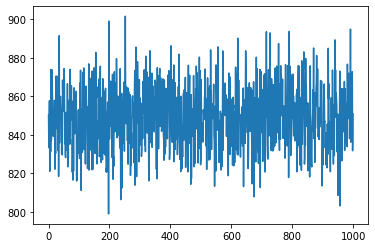

In [41]:
plt.plot(losses)

In [43]:
model.eval()

dun_convlstm(
  (lstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (2): ConvLSTMCell(
        (conv): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
    )
  )
  (output_block): Sequential(
    (0): Dropout2d(p=0.5, inplace=False)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=500, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [45]:
def add_1(arr, front=False):
    if front:
        return arr.reshape([1,*arr.shape])

    return arr.reshape([*arr.shape,1])

input


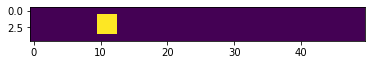

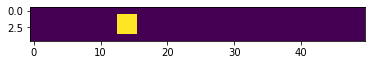

predict next frame


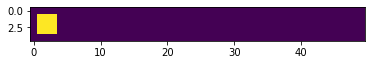

real next frame
/home/praskr/anaconda3/envs/ml-pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


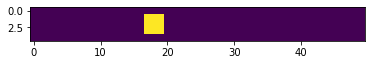

tensor([[1.5150]], device='cuda:0') --------

input


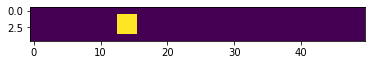

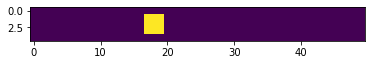

predict next frame


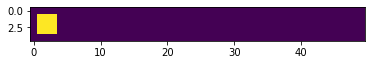

real next frame


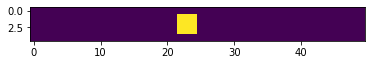

tensor([[1.4361]], device='cuda:0') --------

input


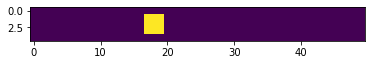

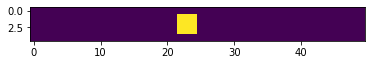

predict next frame


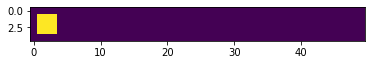

real next frame


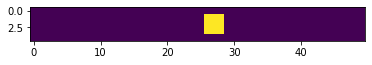

tensor([[1.3492]], device='cuda:0') --------

input


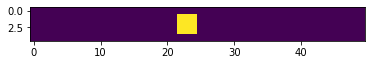

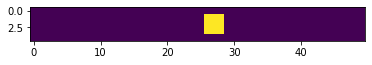

predict next frame


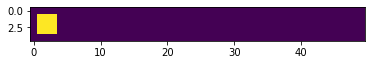

real next frame


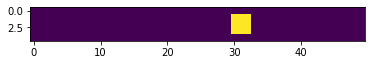

tensor([[1.2920]], device='cuda:0') --------

input


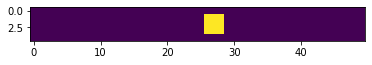

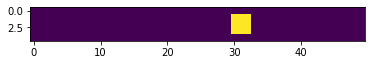

predict next frame


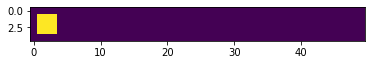

real next frame


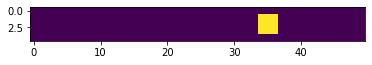

tensor([[1.3613]], device='cuda:0') --------

input


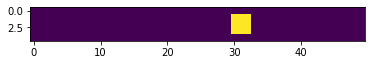

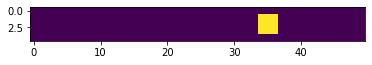

predict next frame


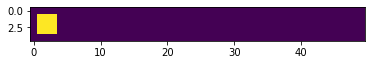

real next frame


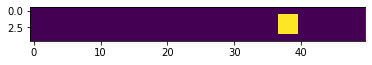

tensor([[1.5246]], device='cuda:0') --------

input


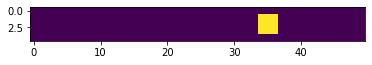

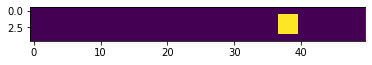

predict next frame


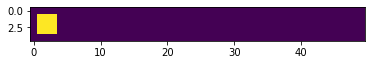

real next frame


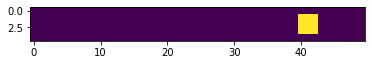

tensor([[1.6665]], device='cuda:0') --------

input


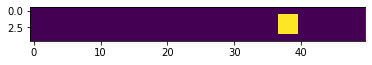

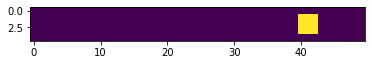

predict next frame


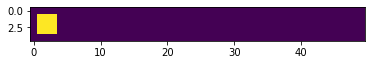

real next frame


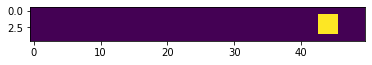

tensor([[1.7630]], device='cuda:0') --------

input


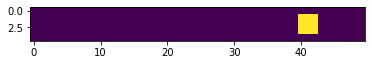

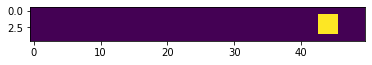

predict next frame


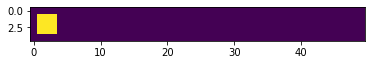

real next frame


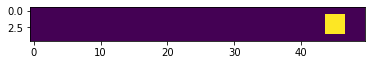

tensor([[1.9729]], device='cuda:0') --------

input


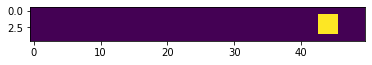

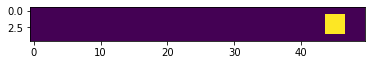

predict next frame


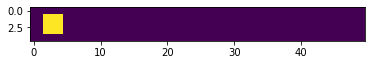

real next frame


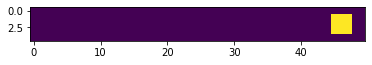

tensor([[2.7452]], device='cuda:0') --------



In [47]:
for frame, output in zip(chron_X[30:40], chron_y[30:40]):
    with torch.no_grad():
        single_frame = torch.tensor(frame).to(device).unsqueeze(0)
        pred = model(single_frame)
        
        print('input')
        plt.imshow(frame[0][0])
        plt.show()
        
        plt.imshow(frame[1][0])
        plt.show()
        
        print('predict next frame')
        plt.imshow(get_array_with_box_at_pos(pred.item()))
        plt.show()
        # break
        
        print('real next frame')
        plt.imshow(get_array_with_box_at_pos(output))
        plt.show()
        print(pred, '--------\n')

In [48]:
x, y = next(iter(trainloader))
print(x.shape)
y_bar = model(x.to(device))
print(y_bar)
print(y)
print(criterion(y.to(device),y_bar))

torch.Size([10, 2, 1, 5, 50])
tensor([[1.4978],
        [1.3276],
        [1.4950],
        [2.7239],
        [1.5150],
        [2.5247],
        [1.3942],
        [2.8039],
        [1.8328],
        [1.4328]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([[16.5471],
        [29.0955],
        [ 5.2971],
        [45.9556],
        [17.9045],
        [44.4200],
        [11.4439],
        [45.8226],
        [34.3395],
        [ 8.0977]])
tensor(89.6756, device='cuda:0', grad_fn=<MulBackward0>)
